In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

# Air Passenger Data

In [40]:
def parser(s):
    return datetime.strptime(s, '%Y-%m')

In [41]:
#read data
air_passenger = pd.read_csv('https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_2/airline-passengers.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [42]:
air_passenger.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64

In [43]:
type(air_passenger)

pandas.core.series.Series

In [44]:
air_passenger.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [45]:
air_passenger = air_passenger.asfreq(pd.infer_freq(air_passenger.index))

In [46]:
start_date = datetime(1954,1,1)
end_date = datetime(1960,12,1)
lim_air_passenger = air_passenger[start_date:end_date]

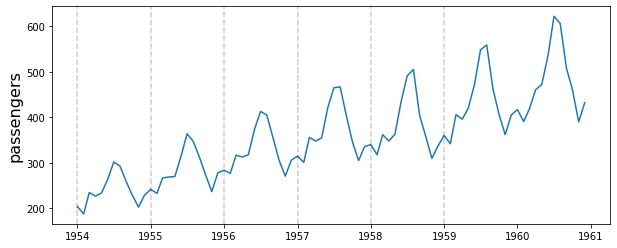

In [47]:
plt.figure(figsize=(10,4))
plt.plot(lim_air_passenger)
plt.ylabel('passengers', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# Introduce an Anomaly

In [48]:
#At December 1 1998
lim_air_passenger[datetime(1954,6,1)] = 800

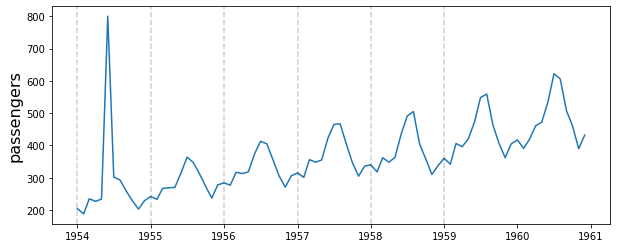

In [49]:
plt.figure(figsize=(10,4))
plt.plot(lim_air_passenger)
plt.ylabel('passengers', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# Remove the trend

In [50]:
first_diff = lim_air_passenger.diff()[1:]

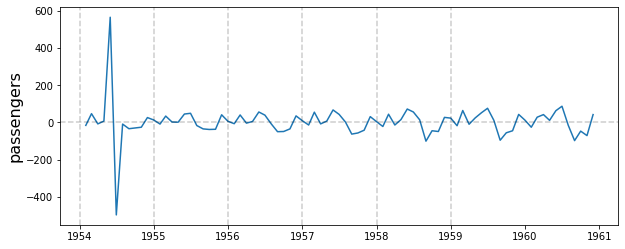

In [51]:

plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.ylabel('passengers', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# Get training and testing sets

In [52]:

train_end = datetime(1959,12,1)
test_end = datetime(1960,12,1)

test_data = lim_air_passenger[train_end + timedelta(days=1):test_end]

# Make Predictions

In [53]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)

In [54]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_air_passenger[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [55]:

rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

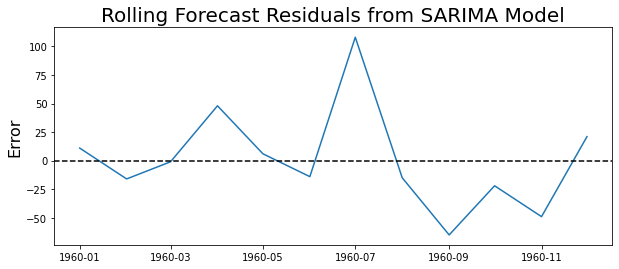

In [56]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

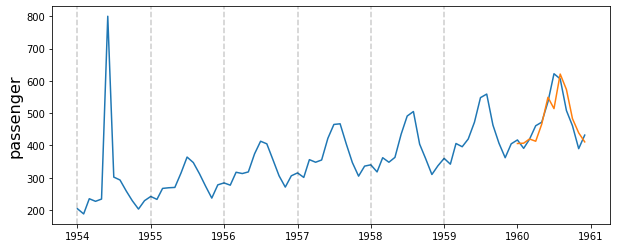

In [57]:
plt.figure(figsize=(10,4))

plt.plot(lim_air_passenger)
plt.plot(rolling_predictions)

plt.ylabel('passenger', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [58]:

print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0634


In [59]:

print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 43.16055297761294


# Detecting the Anomaly

## 1: Deviation Method

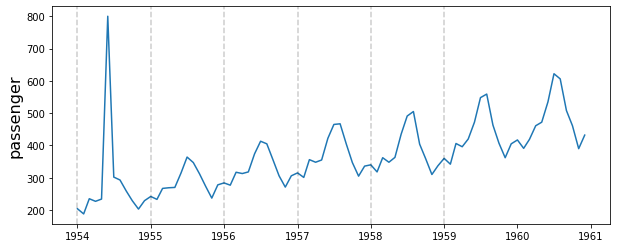

In [60]:

plt.figure(figsize=(10,4))
plt.plot(lim_air_passenger)
plt.ylabel('passenger', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [61]:
rolling_deviations = pd.Series(dtype=float, index = lim_air_passenger.index)

In [62]:
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = lim_air_passenger.loc[:date]
    #print("********")
    #print(window)
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std()
    #print(rolling_deviations.loc[date])

In [63]:

#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

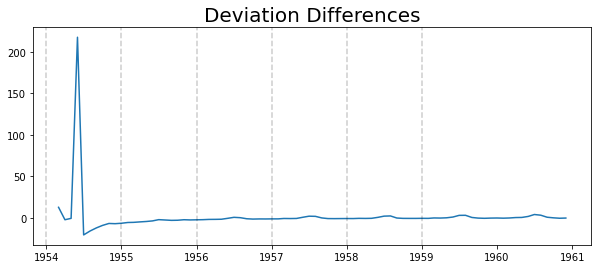

In [64]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## 2: Seasonal Method

In [65]:
month_deviations = lim_air_passenger.groupby(lambda d: d.month).std()

Text(0.5, 1.0, 'Deviation by Month')

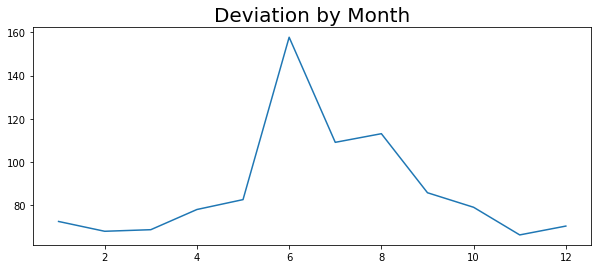

In [66]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)

In [67]:
december_data = lim_air_passenger[lim_air_passenger.index.month == 6]

In [68]:
december_data

Month
1954-06-01    800
1955-06-01    315
1956-06-01    374
1957-06-01    422
1958-06-01    435
1959-06-01    472
1960-06-01    535
Name: Passengers, dtype: int64

In [69]:
min_dev = 9999999
curr_anomaly = None
for date in december_data.index:
    other_data = december_data[december_data.index != date]
    curr_dev = other_data.std()
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

In [70]:
curr_anomaly

Timestamp('1954-06-01 00:00:00')

# Handle the anomaly


## use mean of other months

In [71]:
adjusted_data = lim_air_passenger.copy()
adjusted_data.loc[curr_anomaly] = december_data[(december_data.index != curr_anomaly) & (december_data.index < test_data.index[0])].mean()

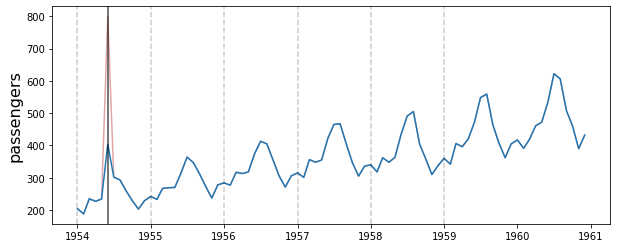

In [72]:
plt.figure(figsize=(10,4))
plt.plot(lim_air_passenger, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)

plt.ylabel('passengers', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

## Resulting Predictions

In [80]:
train_end = datetime(1959,12,1)
test_end = datetime(1960,12,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

In [81]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [82]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

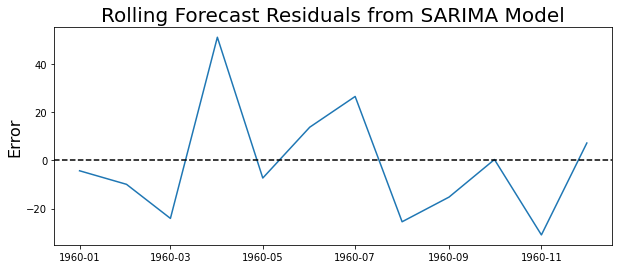

In [83]:

plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

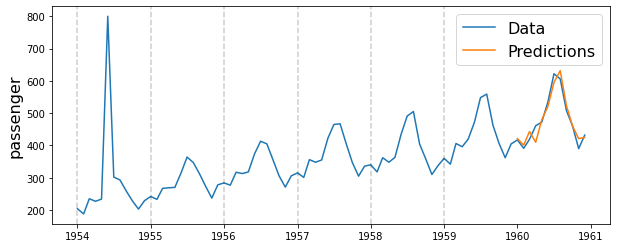

In [87]:
plt.figure(figsize=(10,4))

plt.plot(lim_air_passenger)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.ylabel('passenger', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [85]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0381


In [79]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 22.657684899785362
